# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [ ]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
# model_name = 'swin_base_patch4_window12_384_in22k'
model_name = 'convnext_base_384_in22ft1k'

# training config
img_size = 384
LR = 2e-4
EPOCHS = 50
BATCH_SIZE = 24
num_workers = 8
EMA = True  # Exponential Moving Average 사용 여부

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     # 비율 보존 리사이징 (핵심 개선)
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
    
#     # 문서 특화 회전 (정확한 90도 배수)
#     A.OneOf([
#         A.Rotate(limit=[90,90], p=1.0),
#         A.Rotate(limit=[180,180], p=1.0),
#         A.Rotate(limit=[270,270], p=1.0),
#     ], p=0.6),
    
#     # 테스트 특화 강화 증강
#     A.OneOf([
#         A.MotionBlur(blur_limit=7, p=1.0),
#         A.GaussianBlur(blur_limit=7, p=1.0),
#     ], p=0.9),
    
#     A.RandomBrightnessContrast(
#         brightness_limit=0.3, 
#         contrast_limit=0.3, 
#         p=0.8
#     ),
#     A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
#     A.HorizontalFlip(p=0.5),
    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.05)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2026: 100%|██████████| 14/14 [00:05<00:00,  2.38it/s]

Epoch  1 | Train Loss: 2.0550 | Train F1: 0.3344 | Val Loss: 1.1014 | Val F1: 0.7163



Val Loss: 1.4493: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]

Epoch  2 | Train Loss: 1.1512 | Train F1: 0.6540 | Val Loss: 0.7682 | Val F1: 0.8288



Val Loss: 1.4489: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


Epoch  3 | Train Loss: 0.9150 | Train F1: 0.7193 | Val Loss: 0.6726 | Val F1: 0.8630


Val Loss: 0.8987: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch  4 | Train Loss: 0.8980 | Train F1: 0.6963 | Val Loss: 0.6186 | Val F1: 0.9059


Val Loss: 0.6675: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch  5 | Train Loss: 0.8551 | Train F1: 0.7611 | Val Loss: 0.6021 | Val F1: 0.8936


Val Loss: 0.5143: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


Epoch  6 | Train Loss: 0.7874 | Train F1: 0.7569 | Val Loss: 0.5849 | Val F1: 0.8961


Val Loss: 0.4590: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch  7 | Train Loss: 0.7109 | Train F1: 0.7546 | Val Loss: 0.5410 | Val F1: 0.9186


Val Loss: 0.9536: 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

Epoch  8 | Train Loss: 0.7433 | Train F1: 0.8143 | Val Loss: 0.5419 | Val F1: 0.9286



Val Loss: 1.4685: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch  9 | Train Loss: 0.7564 | Train F1: 0.8063 | Val Loss: 0.5974 | Val F1: 0.8891


Val Loss: 0.9974: 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


Epoch 10 | Train Loss: 0.7539 | Train F1: 0.7621 | Val Loss: 0.5608 | Val F1: 0.9282


Val Loss: 0.9550: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch 11 | Train Loss: 0.6928 | Train F1: 0.8116 | Val Loss: 0.5345 | Val F1: 0.9032


Val Loss: 1.1896: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]


Epoch 12 | Train Loss: 0.7663 | Train F1: 0.7216 | Val Loss: 0.5710 | Val F1: 0.9315


Val Loss: 0.5033: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]


Epoch 13 | Train Loss: 0.7139 | Train F1: 0.7628 | Val Loss: 0.5524 | Val F1: 0.9222


Val Loss: 0.3921: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]

Epoch 14 | Train Loss: 0.6262 | Train F1: 0.8386 | Val Loss: 0.4931 | Val F1: 0.9360



Val Loss: 0.4612: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

Epoch 15 | Train Loss: 0.5816 | Train F1: 0.8855 | Val Loss: 0.5062 | Val F1: 0.9362



Val Loss: 0.3608: 100%|██████████| 14/14 [00:04<00:00,  3.35it/s]


Epoch 16 | Train Loss: 0.5113 | Train F1: 0.8870 | Val Loss: 0.5022 | Val F1: 0.9283


Val Loss: 0.6507: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 17 | Train Loss: 0.6229 | Train F1: 0.8370 | Val Loss: 0.5092 | Val F1: 0.9319


Val Loss: 0.3780: 100%|██████████| 14/14 [00:04<00:00,  3.35it/s]

Epoch 18 | Train Loss: 0.5365 | Train F1: 0.8930 | Val Loss: 0.4859 | Val F1: 0.9421



Val Loss: 0.3616: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 19 | Train Loss: 0.6023 | Train F1: 0.8743 | Val Loss: 0.4832 | Val F1: 0.9364


Val Loss: 0.4782: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch 20 | Train Loss: 0.6514 | Train F1: 0.8058 | Val Loss: 0.4642 | Val F1: 0.9335


Val Loss: 0.5247: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Epoch 21 | Train Loss: 0.5758 | Train F1: 0.8447 | Val Loss: 0.4923 | Val F1: 0.9344


Val Loss: 0.4724: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


Epoch 22 | Train Loss: 0.6393 | Train F1: 0.8129 | Val Loss: 0.4878 | Val F1: 0.9224


Val Loss: 0.4347: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch 23 | Train Loss: 0.5910 | Train F1: 0.8185 | Val Loss: 0.4805 | Val F1: 0.9480


Val Loss: 0.4337: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


Epoch 24 | Train Loss: 0.5179 | Train F1: 0.8920 | Val Loss: 0.4709 | Val F1: 0.9417


Val Loss: 0.3507: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

Epoch 25 | Train Loss: 0.5510 | Train F1: 0.8711 | Val Loss: 0.4820 | Val F1: 0.9495



Val Loss: 0.3954: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Epoch 26 | Train Loss: 0.5852 | Train F1: 0.8380 | Val Loss: 0.4731 | Val F1: 0.9342


Val Loss: 0.3946: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch 27 | Train Loss: 0.6151 | Train F1: 0.7406 | Val Loss: 0.4539 | Val F1: 0.9520


Val Loss: 0.3586: 100%|██████████| 14/14 [00:04<00:00,  3.35it/s]

Epoch 28 | Train Loss: 0.5258 | Train F1: 0.9215 | Val Loss: 0.4495 | Val F1: 0.9607



Val Loss: 0.3293: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch 29 | Train Loss: 0.4944 | Train F1: 0.8281 | Val Loss: 0.4601 | Val F1: 0.9476


Val Loss: 0.5746: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]


Epoch 30 | Train Loss: 0.5444 | Train F1: 0.8887 | Val Loss: 0.4814 | Val F1: 0.9390


Val Loss: 0.3693: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch 31 | Train Loss: 0.5328 | Train F1: 0.8843 | Val Loss: 0.4466 | Val F1: 0.9432


Val Loss: 0.3856: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]


Epoch 32 | Train Loss: 0.5236 | Train F1: 0.8604 | Val Loss: 0.4449 | Val F1: 0.9588


Val Loss: 0.4049: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


Epoch 33 | Train Loss: 0.5356 | Train F1: 0.8834 | Val Loss: 0.4534 | Val F1: 0.9533


Val Loss: 0.6978: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


Epoch 34 | Train Loss: 0.5813 | Train F1: 0.8161 | Val Loss: 0.5027 | Val F1: 0.9419


Val Loss: 0.3800: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch 35 | Train Loss: 0.5374 | Train F1: 0.8529 | Val Loss: 0.4632 | Val F1: 0.9505


Val Loss: 0.3471: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]


Epoch 36 | Train Loss: 0.5675 | Train F1: 0.8093 | Val Loss: 0.4651 | Val F1: 0.9454


Val Loss: 0.5045: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Epoch 37 | Train Loss: 0.5250 | Train F1: 0.8927 | Val Loss: 0.4607 | Val F1: 0.9559


Val Loss: 0.3541: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]

Epoch 38 | Train Loss: 0.5380 | Train F1: 0.8591 | Val Loss: 0.4276 | Val F1: 0.9634



Val Loss: 0.3256: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 39 | Train Loss: 0.5217 | Train F1: 0.9120 | Val Loss: 0.4545 | Val F1: 0.9603


Val Loss: 0.4061: 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]

Epoch 40 | Train Loss: 0.4850 | Train F1: 0.9259 | Val Loss: 0.4376 | Val F1: 0.9667



Val Loss: 0.3346: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


Epoch 41 | Train Loss: 0.5563 | Train F1: 0.8461 | Val Loss: 0.4379 | Val F1: 0.9589


Val Loss: 0.3566: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 42 | Train Loss: 0.5195 | Train F1: 0.8435 | Val Loss: 0.4441 | Val F1: 0.9634


Val Loss: 0.6223: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]


Epoch 43 | Train Loss: 0.5324 | Train F1: 0.8488 | Val Loss: 0.4750 | Val F1: 0.9580


Val Loss: 0.3259: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 44 | Train Loss: 0.4252 | Train F1: 0.9132 | Val Loss: 0.4491 | Val F1: 0.9465


Val Loss: 0.3243: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]


Epoch 45 | Train Loss: 0.5421 | Train F1: 0.8669 | Val Loss: 0.4281 | Val F1: 0.9590


Val Loss: 0.3833: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 46 | Train Loss: 0.5299 | Train F1: 0.8754 | Val Loss: 0.4420 | Val F1: 0.9556


Val Loss: 0.3449: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 47 | Train Loss: 0.5803 | Train F1: 0.8523 | Val Loss: 0.4432 | Val F1: 0.9505


Val Loss: 0.5218: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Epoch 48 | Train Loss: 0.4718 | Train F1: 0.9243 | Val Loss: 0.4561 | Val F1: 0.9588


Val Loss: 0.3753: 100%|██████████| 14/14 [00:03<00:00,  3.90it/s]


Epoch 49 | Train Loss: 0.5878 | Train F1: 0.7889 | Val Loss: 0.4416 | Val F1: 0.9518


Val Loss: 0.3437: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


Epoch 50 | Train Loss: 0.5087 | Train F1: 0.8732 | Val Loss: 0.4499 | Val F1: 0.9504
Fold 1 Best Validation F1: 0.9667

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.3144: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch  1 | Train Loss: 1.9287 | Train F1: 0.4224 | Val Loss: 1.0732 | Val F1: 0.6372


Val Loss: 1.6357: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch  2 | Train Loss: 1.2138 | Train F1: 0.6311 | Val Loss: 0.7647 | Val F1: 0.8370


Val Loss: 1.2277: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch  3 | Train Loss: 1.0301 | Train F1: 0.7341 | Val Loss: 0.7017 | Val F1: 0.8440


Val Loss: 1.3469: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch  4 | Train Loss: 1.0121 | Train F1: 0.7006 | Val Loss: 0.7050 | Val F1: 0.8403


Val Loss: 0.9472: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch  5 | Train Loss: 0.7945 | Train F1: 0.7608 | Val Loss: 0.5797 | Val F1: 0.8757


Val Loss: 1.0069: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch  6 | Train Loss: 0.7588 | Train F1: 0.7854 | Val Loss: 0.6141 | Val F1: 0.8416


Val Loss: 0.5578: 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]

Epoch  7 | Train Loss: 0.8621 | Train F1: 0.7313 | Val Loss: 0.6103 | Val F1: 0.8802



Val Loss: 0.4838: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch  8 | Train Loss: 0.9136 | Train F1: 0.7300 | Val Loss: 0.5508 | Val F1: 0.8848


Val Loss: 0.9173: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch  9 | Train Loss: 0.6285 | Train F1: 0.8719 | Val Loss: 0.5257 | Val F1: 0.9264


Val Loss: 0.5699: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 10 | Train Loss: 0.7436 | Train F1: 0.7887 | Val Loss: 0.4822 | Val F1: 0.9382


Val Loss: 0.7452: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 11 | Train Loss: 0.7052 | Train F1: 0.8195 | Val Loss: 0.5230 | Val F1: 0.9074


Val Loss: 1.1353: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 12 | Train Loss: 0.7075 | Train F1: 0.8211 | Val Loss: 0.5360 | Val F1: 0.9117


Val Loss: 0.4517: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 13 | Train Loss: 0.6591 | Train F1: 0.8105 | Val Loss: 0.4779 | Val F1: 0.9339


Val Loss: 0.5349: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 14 | Train Loss: 0.6798 | Train F1: 0.8339 | Val Loss: 0.4615 | Val F1: 0.9405


Val Loss: 0.4363: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


Epoch 15 | Train Loss: 0.7971 | Train F1: 0.7895 | Val Loss: 0.4637 | Val F1: 0.9433


Val Loss: 0.3771: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 16 | Train Loss: 0.6019 | Train F1: 0.9002 | Val Loss: 0.4705 | Val F1: 0.9435


Val Loss: 0.6163: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch 17 | Train Loss: 0.6665 | Train F1: 0.7833 | Val Loss: 0.4630 | Val F1: 0.9620


Val Loss: 0.4760: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


Epoch 18 | Train Loss: 0.5611 | Train F1: 0.8628 | Val Loss: 0.4567 | Val F1: 0.9609


Val Loss: 0.3554: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 19 | Train Loss: 0.6142 | Train F1: 0.8705 | Val Loss: 0.5027 | Val F1: 0.9331


Val Loss: 1.0836: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 20 | Train Loss: 0.6468 | Train F1: 0.8077 | Val Loss: 0.4985 | Val F1: 0.9528


Val Loss: 0.9060: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 21 | Train Loss: 0.5834 | Train F1: 0.8614 | Val Loss: 0.5035 | Val F1: 0.9482


Val Loss: 0.3958: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch 22 | Train Loss: 0.5551 | Train F1: 0.8546 | Val Loss: 0.4693 | Val F1: 0.9355


Val Loss: 0.3351: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 23 | Train Loss: 0.5783 | Train F1: 0.8581 | Val Loss: 0.4495 | Val F1: 0.9475


Val Loss: 0.4188: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 24 | Train Loss: 0.5639 | Train F1: 0.8985 | Val Loss: 0.4482 | Val F1: 0.9643


Val Loss: 0.3726: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 25 | Train Loss: 0.6565 | Train F1: 0.8170 | Val Loss: 0.4572 | Val F1: 0.9546


Val Loss: 0.3349: 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


Epoch 26 | Train Loss: 0.5661 | Train F1: 0.8931 | Val Loss: 0.4630 | Val F1: 0.9512


Val Loss: 1.4815: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch 27 | Train Loss: 0.6218 | Train F1: 0.8135 | Val Loss: 0.5384 | Val F1: 0.9617


Val Loss: 0.3271: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 28 | Train Loss: 0.5744 | Train F1: 0.8395 | Val Loss: 0.4492 | Val F1: 0.9510


Val Loss: 0.3267: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 29 | Train Loss: 0.5922 | Train F1: 0.8541 | Val Loss: 0.4545 | Val F1: 0.9644


Val Loss: 0.8223: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Epoch 30 | Train Loss: 0.6026 | Train F1: 0.7945 | Val Loss: 0.4837 | Val F1: 0.9585


Val Loss: 1.0088: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 31 | Train Loss: 0.5548 | Train F1: 0.8939 | Val Loss: 0.4904 | Val F1: 0.9602


Val Loss: 0.3379: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 32 | Train Loss: 0.5516 | Train F1: 0.9049 | Val Loss: 0.4496 | Val F1: 0.9529


Val Loss: 0.5252: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 33 | Train Loss: 0.6299 | Train F1: 0.8395 | Val Loss: 0.4474 | Val F1: 0.9638


Val Loss: 0.3368: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 34 | Train Loss: 0.5936 | Train F1: 0.8665 | Val Loss: 0.4421 | Val F1: 0.9690


Val Loss: 0.3850: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 35 | Train Loss: 0.6614 | Train F1: 0.7884 | Val Loss: 0.4335 | Val F1: 0.9691


Val Loss: 0.5724: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 36 | Train Loss: 0.5529 | Train F1: 0.8460 | Val Loss: 0.4565 | Val F1: 0.9695


Val Loss: 0.4138: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 37 | Train Loss: 0.5070 | Train F1: 0.8430 | Val Loss: 0.4363 | Val F1: 0.9576


Val Loss: 0.5825: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 38 | Train Loss: 0.5763 | Train F1: 0.8751 | Val Loss: 0.4531 | Val F1: 0.9562


Val Loss: 0.3840: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 39 | Train Loss: 0.5871 | Train F1: 0.7832 | Val Loss: 0.4303 | Val F1: 0.9754


Val Loss: 0.3494: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch 40 | Train Loss: 0.5835 | Train F1: 0.8564 | Val Loss: 0.4155 | Val F1: 0.9750


Val Loss: 0.4570: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 41 | Train Loss: 0.5555 | Train F1: 0.8669 | Val Loss: 0.4529 | Val F1: 0.9617


Val Loss: 0.4593: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 42 | Train Loss: 0.4786 | Train F1: 0.8938 | Val Loss: 0.4506 | Val F1: 0.9722


Val Loss: 0.3685: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 43 | Train Loss: 0.4683 | Train F1: 0.8974 | Val Loss: 0.4287 | Val F1: 0.9693


Val Loss: 0.3589: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


Epoch 44 | Train Loss: 0.6254 | Train F1: 0.8044 | Val Loss: 0.4102 | Val F1: 0.9724


Val Loss: 0.5395: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 45 | Train Loss: 0.4726 | Train F1: 0.8959 | Val Loss: 0.4342 | Val F1: 0.9782


Val Loss: 0.7207: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 46 | Train Loss: 0.4576 | Train F1: 0.9476 | Val Loss: 0.4786 | Val F1: 0.9470


Val Loss: 0.3528: 100%|██████████| 14/14 [00:04<00:00,  2.93it/s]


Epoch 47 | Train Loss: 0.5924 | Train F1: 0.8478 | Val Loss: 0.4275 | Val F1: 0.9643


Val Loss: 0.3634: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]


Epoch 48 | Train Loss: 0.4684 | Train F1: 0.8867 | Val Loss: 0.4232 | Val F1: 0.9722


Val Loss: 0.3544: 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


Epoch 49 | Train Loss: 0.5138 | Train F1: 0.8781 | Val Loss: 0.4395 | Val F1: 0.9722


Val Loss: 0.4609: 100%|██████████| 14/14 [00:04<00:00,  2.80it/s]


Epoch 50 | Train Loss: 0.4967 | Train F1: 0.8833 | Val Loss: 0.4304 | Val F1: 0.9752
Fold 2 Best Validation F1: 0.9782

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3793: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


Epoch  1 | Train Loss: 1.8496 | Train F1: 0.4376 | Val Loss: 0.8811 | Val F1: 0.7493


Val Loss: 0.3653: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch  2 | Train Loss: 1.0748 | Train F1: 0.6869 | Val Loss: 0.6386 | Val F1: 0.8468


Val Loss: 0.3421: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch  3 | Train Loss: 0.9425 | Train F1: 0.6766 | Val Loss: 0.5908 | Val F1: 0.8573


Val Loss: 0.3348: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch  4 | Train Loss: 0.7776 | Train F1: 0.7868 | Val Loss: 0.5841 | Val F1: 0.8928


Val Loss: 0.3289: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch  5 | Train Loss: 0.8527 | Train F1: 0.7738 | Val Loss: 0.5839 | Val F1: 0.8363


Val Loss: 0.3288: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch  6 | Train Loss: 0.7334 | Train F1: 0.7950 | Val Loss: 0.5551 | Val F1: 0.8722


Val Loss: 0.3385: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch  7 | Train Loss: 0.8354 | Train F1: 0.7576 | Val Loss: 0.5086 | Val F1: 0.8774


Val Loss: 0.3314: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


Epoch  8 | Train Loss: 0.7265 | Train F1: 0.8267 | Val Loss: 0.5117 | Val F1: 0.8918


Val Loss: 0.3339: 100%|██████████| 14/14 [00:04<00:00,  3.22it/s]


Epoch  9 | Train Loss: 0.7233 | Train F1: 0.8334 | Val Loss: 0.5727 | Val F1: 0.8783


Val Loss: 0.3316: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch 10 | Train Loss: 0.7819 | Train F1: 0.7733 | Val Loss: 0.5125 | Val F1: 0.9157


Val Loss: 0.3294: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 11 | Train Loss: 0.7121 | Train F1: 0.8464 | Val Loss: 0.5334 | Val F1: 0.9003


Val Loss: 0.3298: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]


Epoch 12 | Train Loss: 0.6506 | Train F1: 0.8540 | Val Loss: 0.6174 | Val F1: 0.8750


Val Loss: 0.3259: 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


Epoch 13 | Train Loss: 0.6892 | Train F1: 0.8388 | Val Loss: 0.4699 | Val F1: 0.9280


Val Loss: 0.3257: 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]


Epoch 14 | Train Loss: 0.6439 | Train F1: 0.8453 | Val Loss: 0.4969 | Val F1: 0.9219


Val Loss: 0.3290: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 15 | Train Loss: 0.7287 | Train F1: 0.8154 | Val Loss: 0.4726 | Val F1: 0.9335


Val Loss: 0.3278: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch 16 | Train Loss: 0.7168 | Train F1: 0.7866 | Val Loss: 0.4450 | Val F1: 0.9335


Val Loss: 0.3233: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 17 | Train Loss: 0.6525 | Train F1: 0.7774 | Val Loss: 0.4894 | Val F1: 0.9074


Val Loss: 0.3224: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 18 | Train Loss: 0.5542 | Train F1: 0.8929 | Val Loss: 0.4778 | Val F1: 0.9243


Val Loss: 0.3239: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


Epoch 19 | Train Loss: 0.5814 | Train F1: 0.8840 | Val Loss: 0.4547 | Val F1: 0.9358


Val Loss: 0.3250: 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch 20 | Train Loss: 0.6522 | Train F1: 0.8295 | Val Loss: 0.4885 | Val F1: 0.9304


Val Loss: 0.3239: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 21 | Train Loss: 0.5671 | Train F1: 0.8855 | Val Loss: 0.5112 | Val F1: 0.9207


Val Loss: 0.3245: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 22 | Train Loss: 0.5666 | Train F1: 0.8750 | Val Loss: 0.4712 | Val F1: 0.9355


Val Loss: 0.3268: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 23 | Train Loss: 0.5440 | Train F1: 0.8716 | Val Loss: 0.4742 | Val F1: 0.9368


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]


Epoch 24 | Train Loss: 0.6278 | Train F1: 0.8148 | Val Loss: 0.4819 | Val F1: 0.9295


Val Loss: 0.3229: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 25 | Train Loss: 0.5668 | Train F1: 0.8072 | Val Loss: 0.5005 | Val F1: 0.9168


Val Loss: 0.3245: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

Epoch 26 | Train Loss: 0.5221 | Train F1: 0.8493 | Val Loss: 0.4702 | Val F1: 0.9456



Val Loss: 0.3248: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 27 | Train Loss: 0.6527 | Train F1: 0.8029 | Val Loss: 0.4774 | Val F1: 0.9414


Val Loss: 0.3239: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 28 | Train Loss: 0.5538 | Train F1: 0.8405 | Val Loss: 0.4488 | Val F1: 0.9476


Val Loss: 0.3228: 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]


Epoch 29 | Train Loss: 0.5515 | Train F1: 0.9229 | Val Loss: 0.4766 | Val F1: 0.9498


Val Loss: 0.3238: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 30 | Train Loss: 0.6289 | Train F1: 0.8605 | Val Loss: 0.4569 | Val F1: 0.9447


Val Loss: 0.3253: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch 31 | Train Loss: 0.5393 | Train F1: 0.8666 | Val Loss: 0.4686 | Val F1: 0.9385


Val Loss: 0.3224: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 32 | Train Loss: 0.5558 | Train F1: 0.8594 | Val Loss: 0.4314 | Val F1: 0.9585


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 33 | Train Loss: 0.5324 | Train F1: 0.8763 | Val Loss: 0.4707 | Val F1: 0.9418


Val Loss: 0.3217: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 34 | Train Loss: 0.4640 | Train F1: 0.8858 | Val Loss: 0.4563 | Val F1: 0.9492


Val Loss: 0.3217: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 35 | Train Loss: 0.5805 | Train F1: 0.7804 | Val Loss: 0.4468 | Val F1: 0.9433


Val Loss: 0.3227: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 36 | Train Loss: 0.5248 | Train F1: 0.8974 | Val Loss: 0.4423 | Val F1: 0.9472


Val Loss: 0.3220: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 37 | Train Loss: 0.5357 | Train F1: 0.8980 | Val Loss: 0.4539 | Val F1: 0.9498


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 38 | Train Loss: 0.5587 | Train F1: 0.8210 | Val Loss: 0.4185 | Val F1: 0.9605


Val Loss: 0.3215: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 39 | Train Loss: 0.5480 | Train F1: 0.8684 | Val Loss: 0.4433 | Val F1: 0.9388


Val Loss: 0.3219: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


Epoch 40 | Train Loss: 0.5369 | Train F1: 0.8758 | Val Loss: 0.4219 | Val F1: 0.9530


Val Loss: 0.3222: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 41 | Train Loss: 0.6202 | Train F1: 0.7759 | Val Loss: 0.4531 | Val F1: 0.9529


Val Loss: 0.3219: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 42 | Train Loss: 0.5205 | Train F1: 0.8742 | Val Loss: 0.4341 | Val F1: 0.9555


Val Loss: 0.3214: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 43 | Train Loss: 0.5163 | Train F1: 0.8544 | Val Loss: 0.4425 | Val F1: 0.9532


Val Loss: 0.3213: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 44 | Train Loss: 0.5392 | Train F1: 0.8770 | Val Loss: 0.4589 | Val F1: 0.9563


Val Loss: 0.3222: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 45 | Train Loss: 0.5463 | Train F1: 0.8252 | Val Loss: 0.4190 | Val F1: 0.9528


Val Loss: 0.3210: 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]


Epoch 46 | Train Loss: 0.5888 | Train F1: 0.8192 | Val Loss: 0.4375 | Val F1: 0.9644


Val Loss: 0.3215: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 47 | Train Loss: 0.5884 | Train F1: 0.8248 | Val Loss: 0.4325 | Val F1: 0.9615


Val Loss: 0.3216: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Epoch 48 | Train Loss: 0.5246 | Train F1: 0.8885 | Val Loss: 0.4271 | Val F1: 0.9592


Val Loss: 0.3217: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 49 | Train Loss: 0.5394 | Train F1: 0.8357 | Val Loss: 0.4218 | Val F1: 0.9708


Val Loss: 0.3212: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 50 | Train Loss: 0.5479 | Train F1: 0.8631 | Val Loss: 0.4505 | Val F1: 0.9612
Fold 3 Best Validation F1: 0.9708

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3838: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch  1 | Train Loss: 1.9294 | Train F1: 0.4051 | Val Loss: 1.0377 | Val F1: 0.7067


Val Loss: 0.3552: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

Epoch  2 | Train Loss: 1.1030 | Train F1: 0.6489 | Val Loss: 0.7394 | Val F1: 0.8138



Val Loss: 0.3338: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch  3 | Train Loss: 0.9878 | Train F1: 0.7134 | Val Loss: 0.6678 | Val F1: 0.7996


Val Loss: 0.3433: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch  4 | Train Loss: 0.8745 | Train F1: 0.7564 | Val Loss: 0.6177 | Val F1: 0.8499


Val Loss: 0.3379: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]


Epoch  5 | Train Loss: 0.7776 | Train F1: 0.7695 | Val Loss: 0.5831 | Val F1: 0.8596


Val Loss: 0.3568: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


Epoch  6 | Train Loss: 0.8140 | Train F1: 0.7948 | Val Loss: 0.5415 | Val F1: 0.8858


Val Loss: 0.3322: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch  7 | Train Loss: 0.6972 | Train F1: 0.8152 | Val Loss: 0.5357 | Val F1: 0.9170


Val Loss: 0.3344: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch  8 | Train Loss: 0.8730 | Train F1: 0.7860 | Val Loss: 0.5206 | Val F1: 0.9084


Val Loss: 0.3273: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch  9 | Train Loss: 0.7255 | Train F1: 0.7854 | Val Loss: 0.5385 | Val F1: 0.9036


Val Loss: 0.3255: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 10 | Train Loss: 0.6094 | Train F1: 0.8560 | Val Loss: 0.4829 | Val F1: 0.9307


Val Loss: 0.3274: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 11 | Train Loss: 0.7078 | Train F1: 0.7866 | Val Loss: 0.5018 | Val F1: 0.9089


Val Loss: 0.3249: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 12 | Train Loss: 0.6709 | Train F1: 0.8491 | Val Loss: 0.4883 | Val F1: 0.9186


Val Loss: 0.3326: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 13 | Train Loss: 0.6400 | Train F1: 0.8193 | Val Loss: 0.5266 | Val F1: 0.9098


Val Loss: 0.3238: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch 14 | Train Loss: 0.6773 | Train F1: 0.8460 | Val Loss: 0.4957 | Val F1: 0.9185


Val Loss: 0.3243: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 15 | Train Loss: 0.6692 | Train F1: 0.8101 | Val Loss: 0.4691 | Val F1: 0.9392


Val Loss: 0.3258: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]

Epoch 16 | Train Loss: 0.7461 | Train F1: 0.7812 | Val Loss: 0.4801 | Val F1: 0.9412



Val Loss: 0.3306: 100%|██████████| 14/14 [00:04<00:00,  3.24it/s]


Epoch 17 | Train Loss: 0.6623 | Train F1: 0.8582 | Val Loss: 0.4695 | Val F1: 0.9251


Val Loss: 0.3221: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 18 | Train Loss: 0.5559 | Train F1: 0.8255 | Val Loss: 0.5150 | Val F1: 0.9194


Val Loss: 0.3222: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 19 | Train Loss: 0.6610 | Train F1: 0.8077 | Val Loss: 0.4961 | Val F1: 0.9270


Val Loss: 0.3241: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]


Epoch 20 | Train Loss: 0.6434 | Train F1: 0.8345 | Val Loss: 0.4644 | Val F1: 0.9351


Val Loss: 0.3253: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]


Epoch 21 | Train Loss: 0.6081 | Train F1: 0.8212 | Val Loss: 0.4722 | Val F1: 0.9395


Val Loss: 0.3229: 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]


Epoch 22 | Train Loss: 0.6082 | Train F1: 0.8555 | Val Loss: 0.4881 | Val F1: 0.9318


Val Loss: 0.3226: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 23 | Train Loss: 0.5895 | Train F1: 0.8536 | Val Loss: 0.4822 | Val F1: 0.9368


Val Loss: 0.3246: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]


Epoch 24 | Train Loss: 0.5369 | Train F1: 0.8562 | Val Loss: 0.4556 | Val F1: 0.9343


Val Loss: 0.3218: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 25 | Train Loss: 0.5941 | Train F1: 0.8799 | Val Loss: 0.4648 | Val F1: 0.9347


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 26 | Train Loss: 0.5825 | Train F1: 0.8458 | Val Loss: 0.4912 | Val F1: 0.9263


Val Loss: 0.3242: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 27 | Train Loss: 0.5817 | Train F1: 0.8226 | Val Loss: 0.4588 | Val F1: 0.9477


Val Loss: 0.3216: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 28 | Train Loss: 0.5280 | Train F1: 0.9029 | Val Loss: 0.4799 | Val F1: 0.9389


Val Loss: 0.3209: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]


Epoch 29 | Train Loss: 0.5537 | Train F1: 0.8328 | Val Loss: 0.4990 | Val F1: 0.9457


Val Loss: 0.3231: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]

Epoch 30 | Train Loss: 0.6015 | Train F1: 0.7855 | Val Loss: 0.4405 | Val F1: 0.9495



Val Loss: 0.3212: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 31 | Train Loss: 0.6516 | Train F1: 0.7628 | Val Loss: 0.4368 | Val F1: 0.9660


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 32 | Train Loss: 0.5792 | Train F1: 0.9007 | Val Loss: 0.4513 | Val F1: 0.9476


Val Loss: 0.3230: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 33 | Train Loss: 0.4772 | Train F1: 0.8736 | Val Loss: 0.4755 | Val F1: 0.9477


Val Loss: 0.3252: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 34 | Train Loss: 0.5929 | Train F1: 0.7636 | Val Loss: 0.4424 | Val F1: 0.9489


Val Loss: 0.3222: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 35 | Train Loss: 0.5332 | Train F1: 0.8468 | Val Loss: 0.4561 | Val F1: 0.9474


Val Loss: 0.3258: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 36 | Train Loss: 0.5066 | Train F1: 0.8552 | Val Loss: 0.4847 | Val F1: 0.9533


Val Loss: 0.3213: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 37 | Train Loss: 0.5058 | Train F1: 0.9037 | Val Loss: 0.4510 | Val F1: 0.9595


Val Loss: 0.3213: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


Epoch 38 | Train Loss: 0.5930 | Train F1: 0.8089 | Val Loss: 0.4414 | Val F1: 0.9565


Val Loss: 0.3214: 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


Epoch 39 | Train Loss: 0.5848 | Train F1: 0.8564 | Val Loss: 0.4488 | Val F1: 0.9626


Val Loss: 0.3213: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


Epoch 40 | Train Loss: 0.5685 | Train F1: 0.8343 | Val Loss: 0.4632 | Val F1: 0.9489


Val Loss: 0.3212: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 41 | Train Loss: 0.5602 | Train F1: 0.8740 | Val Loss: 0.4642 | Val F1: 0.9550


Val Loss: 0.3213: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 42 | Train Loss: 0.4827 | Train F1: 0.8883 | Val Loss: 0.4379 | Val F1: 0.9427


Val Loss: 0.3211: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 43 | Train Loss: 0.5814 | Train F1: 0.8960 | Val Loss: 0.4720 | Val F1: 0.9361


Val Loss: 0.3208: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 44 | Train Loss: 0.5147 | Train F1: 0.8436 | Val Loss: 0.4507 | Val F1: 0.9485


Val Loss: 0.3228: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 45 | Train Loss: 0.5494 | Train F1: 0.8721 | Val Loss: 0.4555 | Val F1: 0.9454


Val Loss: 0.3211: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]


Epoch 46 | Train Loss: 0.5365 | Train F1: 0.8629 | Val Loss: 0.4291 | Val F1: 0.9635


Val Loss: 0.3212: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 47 | Train Loss: 0.5382 | Train F1: 0.8719 | Val Loss: 0.4507 | Val F1: 0.9459


Val Loss: 0.3214: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


Epoch 48 | Train Loss: 0.5788 | Train F1: 0.8236 | Val Loss: 0.4414 | Val F1: 0.9607


Val Loss: 0.3209: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 49 | Train Loss: 0.5498 | Train F1: 0.8518 | Val Loss: 0.4415 | Val F1: 0.9545


Val Loss: 0.3209: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]


Epoch 50 | Train Loss: 0.5907 | Train F1: 0.8588 | Val Loss: 0.4402 | Val F1: 0.9590
Fold 4 Best Validation F1: 0.9660

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 0.3703: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch  1 | Train Loss: 1.9055 | Train F1: 0.4317 | Val Loss: 1.0046 | Val F1: 0.7121


Val Loss: 0.3757: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch  2 | Train Loss: 1.1863 | Train F1: 0.6614 | Val Loss: 0.7158 | Val F1: 0.8242


Val Loss: 0.3406: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]

Epoch  3 | Train Loss: 0.8641 | Train F1: 0.7735 | Val Loss: 0.6080 | Val F1: 0.8419



Val Loss: 0.3325: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]

Epoch  4 | Train Loss: 0.9410 | Train F1: 0.7359 | Val Loss: 0.6156 | Val F1: 0.8995



Val Loss: 0.3339: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch  5 | Train Loss: 0.8787 | Train F1: 0.7302 | Val Loss: 0.5886 | Val F1: 0.8618


Val Loss: 0.3305: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch  6 | Train Loss: 0.8778 | Train F1: 0.7463 | Val Loss: 0.5411 | Val F1: 0.9241


Val Loss: 0.3311: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch  7 | Train Loss: 0.7771 | Train F1: 0.8098 | Val Loss: 0.5496 | Val F1: 0.8896


Val Loss: 0.3311: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Epoch  8 | Train Loss: 0.6854 | Train F1: 0.8221 | Val Loss: 0.5825 | Val F1: 0.8741


Val Loss: 0.3293: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch  9 | Train Loss: 0.6380 | Train F1: 0.8477 | Val Loss: 0.5376 | Val F1: 0.9056


Val Loss: 0.3306: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 10 | Train Loss: 0.7012 | Train F1: 0.8130 | Val Loss: 0.4952 | Val F1: 0.9191


Val Loss: 0.3294: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 11 | Train Loss: 0.6508 | Train F1: 0.8308 | Val Loss: 0.5176 | Val F1: 0.9189


Val Loss: 0.3517: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 12 | Train Loss: 0.6353 | Train F1: 0.8722 | Val Loss: 0.5020 | Val F1: 0.9149


Val Loss: 0.3465: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 13 | Train Loss: 0.6735 | Train F1: 0.7829 | Val Loss: 0.4917 | Val F1: 0.9238


Val Loss: 0.3329: 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


Epoch 14 | Train Loss: 0.7119 | Train F1: 0.8299 | Val Loss: 0.5165 | Val F1: 0.9238


Val Loss: 0.3303: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 15 | Train Loss: 0.6510 | Train F1: 0.8133 | Val Loss: 0.4940 | Val F1: 0.9293


Val Loss: 0.3321: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 16 | Train Loss: 0.6983 | Train F1: 0.7819 | Val Loss: 0.4772 | Val F1: 0.9375


Val Loss: 0.3375: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 17 | Train Loss: 0.6065 | Train F1: 0.8552 | Val Loss: 0.4962 | Val F1: 0.9189


Val Loss: 0.3375: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Epoch 18 | Train Loss: 0.6169 | Train F1: 0.8139 | Val Loss: 0.5166 | Val F1: 0.9118


Val Loss: 0.3285: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 19 | Train Loss: 0.6402 | Train F1: 0.8167 | Val Loss: 0.4954 | Val F1: 0.9352


Val Loss: 0.3269: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 20 | Train Loss: 0.5850 | Train F1: 0.9192 | Val Loss: 0.4782 | Val F1: 0.9418


Val Loss: 0.3284: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 21 | Train Loss: 0.5984 | Train F1: 0.8727 | Val Loss: 0.4655 | Val F1: 0.9361


Val Loss: 0.3251: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]


Epoch 22 | Train Loss: 0.6267 | Train F1: 0.8733 | Val Loss: 0.4744 | Val F1: 0.9463


Val Loss: 0.3261: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 23 | Train Loss: 0.6224 | Train F1: 0.8573 | Val Loss: 0.5317 | Val F1: 0.9245


Val Loss: 0.3266: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


Epoch 24 | Train Loss: 0.5900 | Train F1: 0.8799 | Val Loss: 0.4745 | Val F1: 0.9469


Val Loss: 0.3236: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


Epoch 25 | Train Loss: 0.5900 | Train F1: 0.8335 | Val Loss: 0.4860 | Val F1: 0.9295


Val Loss: 0.3269: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 26 | Train Loss: 0.5576 | Train F1: 0.8632 | Val Loss: 0.4958 | Val F1: 0.9468


Val Loss: 0.3233: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 27 | Train Loss: 0.4792 | Train F1: 0.9135 | Val Loss: 0.4494 | Val F1: 0.9463


Val Loss: 0.3379: 100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


Epoch 28 | Train Loss: 0.5174 | Train F1: 0.9237 | Val Loss: 0.4954 | Val F1: 0.9402


Val Loss: 0.3235: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 29 | Train Loss: 0.5453 | Train F1: 0.8557 | Val Loss: 0.5009 | Val F1: 0.9378


Val Loss: 0.3239: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 30 | Train Loss: 0.4457 | Train F1: 0.8985 | Val Loss: 0.4738 | Val F1: 0.9507


Val Loss: 0.3229: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 31 | Train Loss: 0.5752 | Train F1: 0.8493 | Val Loss: 0.4829 | Val F1: 0.9464


Val Loss: 0.3239: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 32 | Train Loss: 0.5220 | Train F1: 0.8806 | Val Loss: 0.4698 | Val F1: 0.9562


Val Loss: 0.3241: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 33 | Train Loss: 0.4847 | Train F1: 0.8509 | Val Loss: 0.4918 | Val F1: 0.9499


Val Loss: 0.3223: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 34 | Train Loss: 0.5430 | Train F1: 0.8820 | Val Loss: 0.4807 | Val F1: 0.9414


Val Loss: 0.3246: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 35 | Train Loss: 0.5965 | Train F1: 0.7806 | Val Loss: 0.4797 | Val F1: 0.9493


Val Loss: 0.3234: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 36 | Train Loss: 0.5312 | Train F1: 0.8964 | Val Loss: 0.4601 | Val F1: 0.9565


Val Loss: 0.3229: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


Epoch 37 | Train Loss: 0.5486 | Train F1: 0.8399 | Val Loss: 0.4996 | Val F1: 0.9374


Val Loss: 0.3227: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


Epoch 38 | Train Loss: 0.5113 | Train F1: 0.8823 | Val Loss: 0.4935 | Val F1: 0.9485


Val Loss: 0.3225: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]


Epoch 39 | Train Loss: 0.5360 | Train F1: 0.8794 | Val Loss: 0.4921 | Val F1: 0.9525


Val Loss: 0.3233: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 40 | Train Loss: 0.5644 | Train F1: 0.8217 | Val Loss: 0.4524 | Val F1: 0.9558


Val Loss: 0.3226: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


Epoch 41 | Train Loss: 0.6069 | Train F1: 0.8255 | Val Loss: 0.4669 | Val F1: 0.9580


Val Loss: 0.3226: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 42 | Train Loss: 0.5459 | Train F1: 0.8553 | Val Loss: 0.4767 | Val F1: 0.9505


Val Loss: 0.3221: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


Epoch 43 | Train Loss: 0.5139 | Train F1: 0.7927 | Val Loss: 0.4711 | Val F1: 0.9582


Val Loss: 0.3232: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


Epoch 44 | Train Loss: 0.5515 | Train F1: 0.8496 | Val Loss: 0.4630 | Val F1: 0.9453


Val Loss: 0.3217: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 45 | Train Loss: 0.6105 | Train F1: 0.8321 | Val Loss: 0.4638 | Val F1: 0.9576


Val Loss: 0.3223: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


Epoch 46 | Train Loss: 0.5640 | Train F1: 0.8064 | Val Loss: 0.4640 | Val F1: 0.9557


Val Loss: 0.3230: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


Epoch 47 | Train Loss: 0.4950 | Train F1: 0.8190 | Val Loss: 0.4700 | Val F1: 0.9551


Val Loss: 0.3232: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]


Epoch 48 | Train Loss: 0.5335 | Train F1: 0.8668 | Val Loss: 0.5025 | Val F1: 0.9395


Val Loss: 0.3243: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


Epoch 49 | Train Loss: 0.4089 | Train F1: 0.9291 | Val Loss: 0.4690 | Val F1: 0.9542


Val Loss: 0.3226: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

Epoch 50 | Train Loss: 0.5176 | Train F1: 0.8659 | Val Loss: 0.4540 | Val F1: 0.9548
Fold 5 Best Validation F1: 0.9582

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9667
Fold 2: 0.9782
Fold 3: 0.9708
Fold 4: 0.9660
Fold 5: 0.9582

Mean CV F1: 0.9680 ± 0.0065
Best single fold: 0.9782


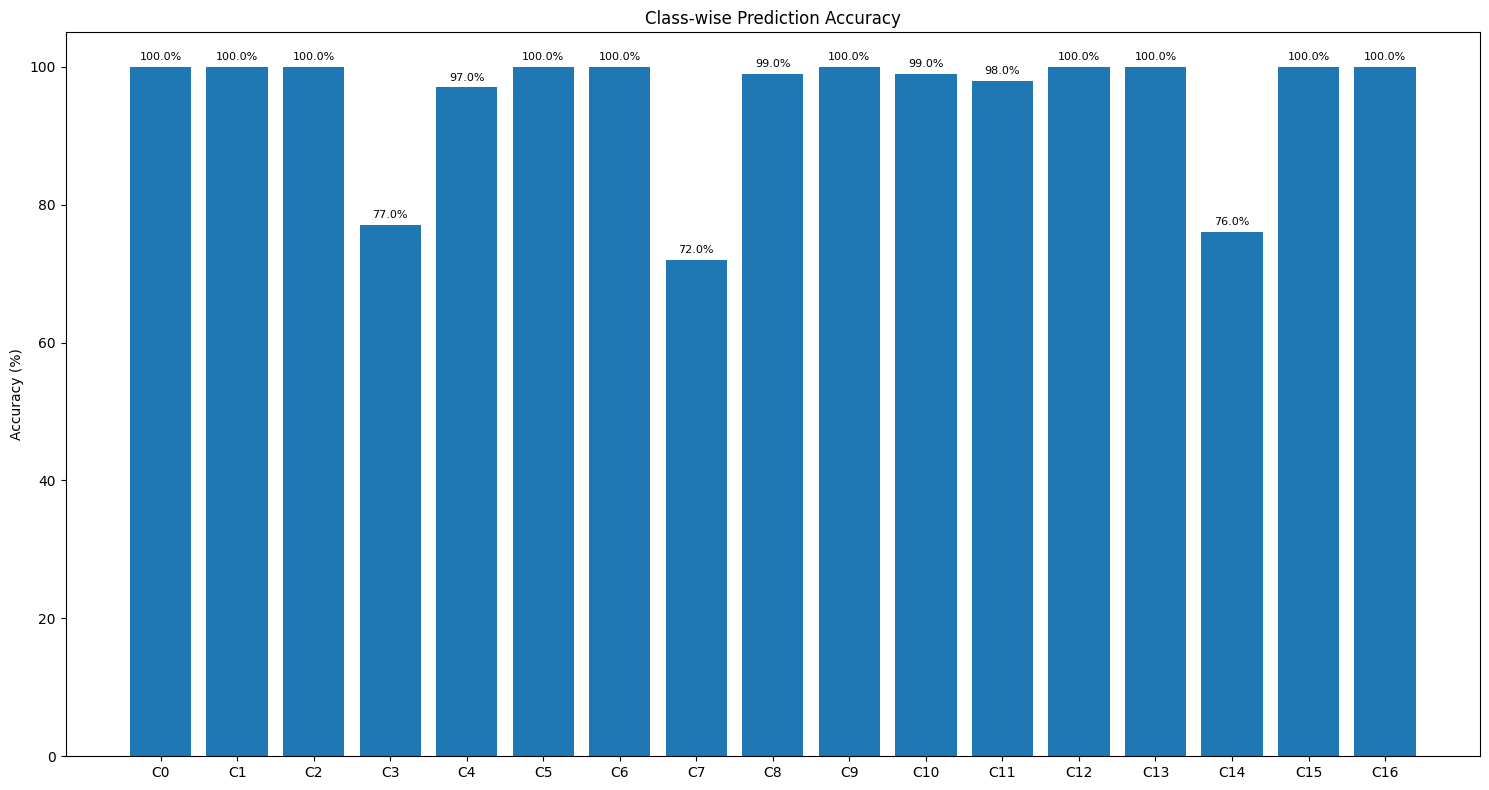

Worst 3 classes:
Class 7: 72.0%
Class 14: 76.0%
Class 3: 77.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [14]:
# # load model
# model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=17
# ).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=LR)

In [15]:
# for epoch in range(EPOCHS):
#     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [17]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [18]:
# sample_submission_df = pd.read_csv("../data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [19]:
# pred_df.to_csv("pred.csv", index=False)

In [20]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [21]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [22]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [23]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [ ]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

: 

In [ ]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [ ]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [ ]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [ ]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
